In [1]:
import sys
print(sys.version)
print(sys.executable)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
C:\Users\87252\anaconda3\envs\FGSM\python.exe


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets,models

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

53.6%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%
100.0%
100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [6]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [7]:
torch.cuda. is_available()

True

In [8]:
# ATTACK
# Attack on VGG16

In [9]:
class VGG16_for_MNIST(nn.Module):
    def __init__(self):
        super(VGG16_for_MNIST, self).__init__()
        original_vgg16 = models.vgg16(pretrained=True)
        self.features = original_vgg16.features

        # Adapt the classifier part of VGG16 for MNIST
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjust the first layer to match the feature map size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )

        # Override the forward method
    def forward(self, x):
        # VGG16 expects 3 channel input, so replicate the grayscale MNIST image across 3 channels
        x = x.repeat(1, 3, 1, 1)  # Input is [N, 1, 28, 28] but needs to be [N, 3, 28, 28]
        x = F.interpolate(x, size=(224, 224))  # Resize images from 28x28 to 224x224
        x = self.features(x)  # Apply VGG16 features
        x = torch.flatten(x, 1)
        x = self.classifier(x)  # Classify with the modified classifier
        return F.log_softmax(x, dim=1)

In [10]:
model = VGG16_for_MNIST().to(device)

C:\Users\87252\anaconda3\envs\FGSM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\87252\anaconda3\envs\FGSM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\87252/.cache\torch\hub\checkpoints\vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Curr

In [11]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [12]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [13]:
loss,val_loss=fit(model,device,train_loader,val_loader,5) # 10 is better but too long time

Fitting the model...
Epoch: 1 Loss: 0.16564774567956184 Val_Loss: 0.0645462218015044
Epoch: 2 Loss: 0.10275944706093593 Val_Loss: 0.09907374574462748
Epoch: 3 Loss: 0.09603686188348959 Val_Loss: 0.08129354760838908
Epoch: 4 Loss: 0.09847866932076635 Val_Loss: 0.0695496358547248
Epoch: 5 Loss: 0.09646417052553827 Val_Loss: 0.11994086083555484


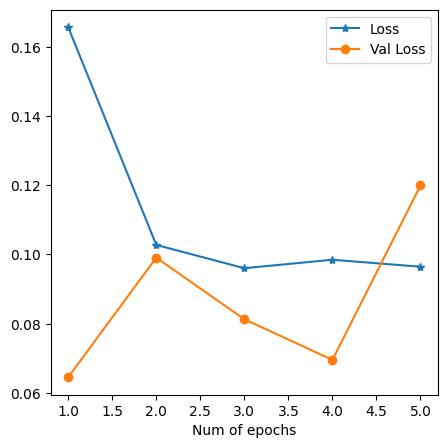

In [14]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,6), loss, "*-",label="Loss")
plt.plot(np.arange(1,6), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [15]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [16]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9801 / 10000 = 0.9801
Epsilon: 0.05	Test Accuracy = 9575 / 10000 = 0.9575
Epsilon: 0.1	Test Accuracy = 9376 / 10000 = 0.9376
Epsilon: 0.2	Test Accuracy = 4684 / 10000 = 0.4684
Epsilon: 0.3	Test Accuracy = 2688 / 10000 = 0.2688


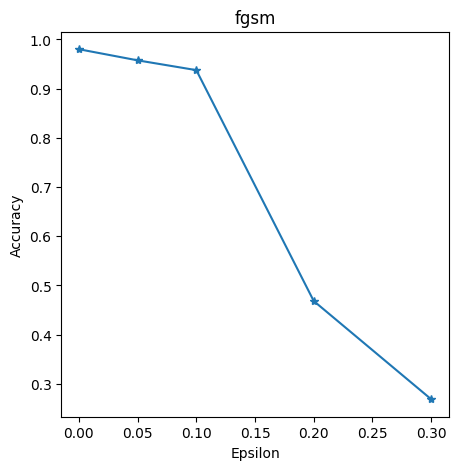

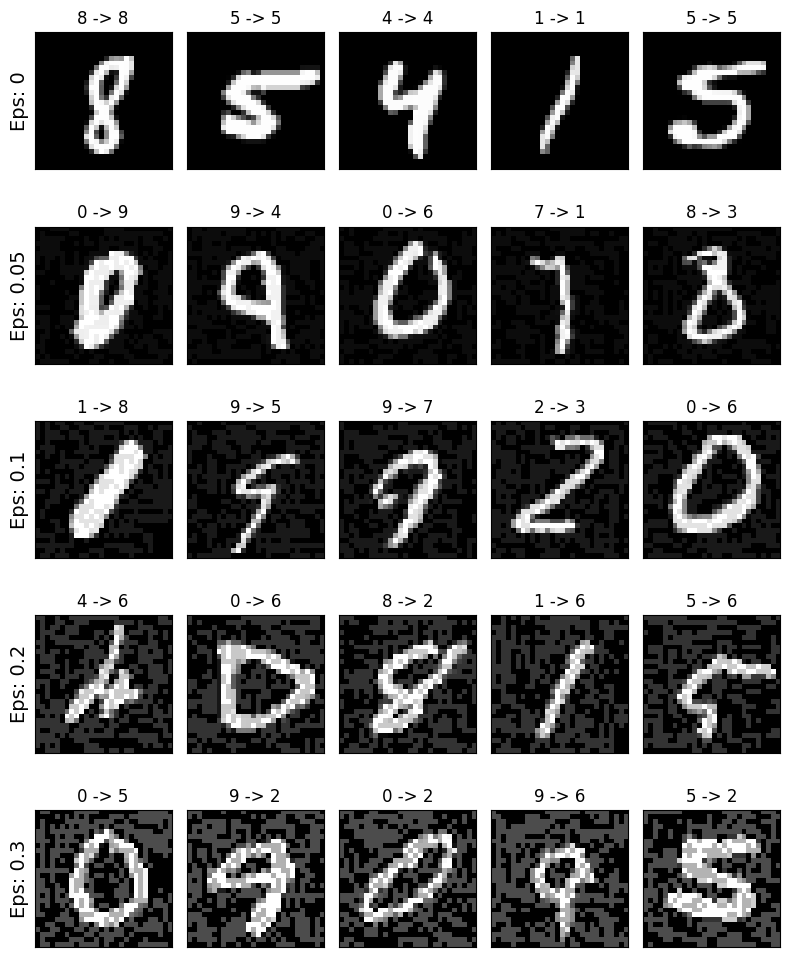

Epsilon: 0	Test Accuracy = 9813 / 10000 = 0.9813
Epsilon: 0.05	Test Accuracy = 9616 / 10000 = 0.9616
Epsilon: 0.1	Test Accuracy = 9427 / 10000 = 0.9427
Epsilon: 0.2	Test Accuracy = 5713 / 10000 = 0.5713
Epsilon: 0.3	Test Accuracy = 2962 / 10000 = 0.2962


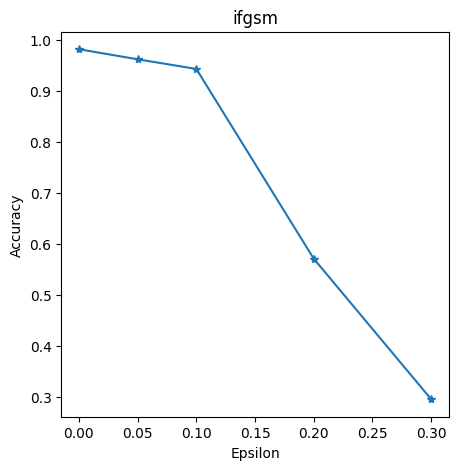

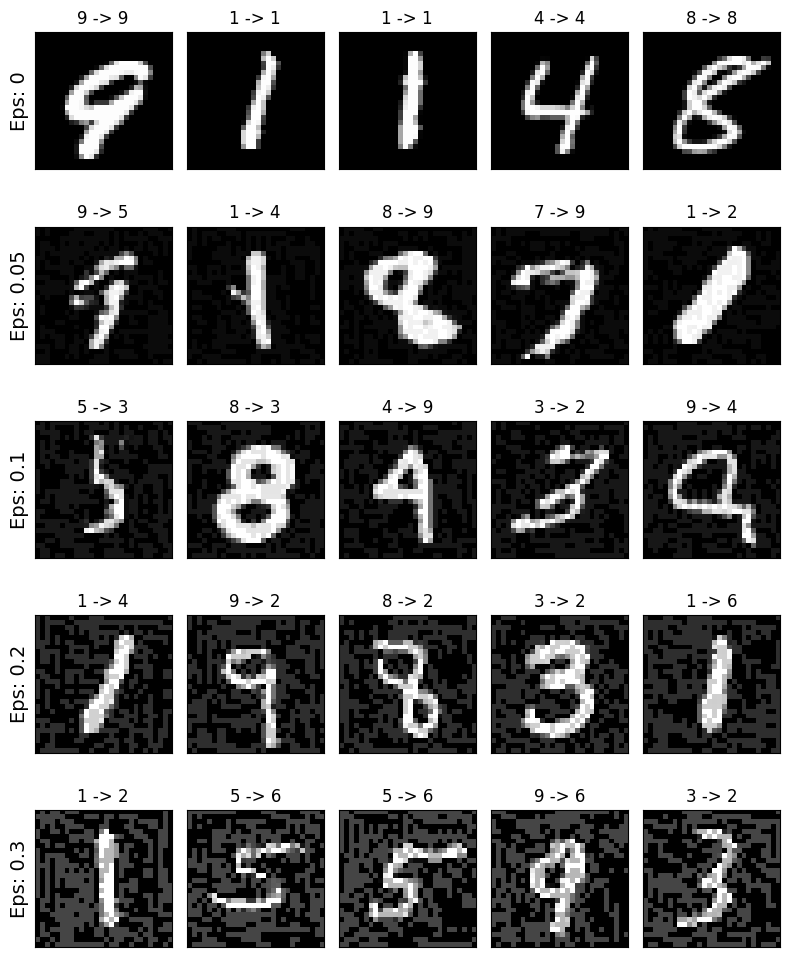

Epsilon: 0	Test Accuracy = 9803 / 10000 = 0.9803
Epsilon: 0.05	Test Accuracy = 9619 / 10000 = 0.9619
Epsilon: 0.1	Test Accuracy = 9439 / 10000 = 0.9439
Epsilon: 0.2	Test Accuracy = 5728 / 10000 = 0.5728
Epsilon: 0.3	Test Accuracy = 2982 / 10000 = 0.2982


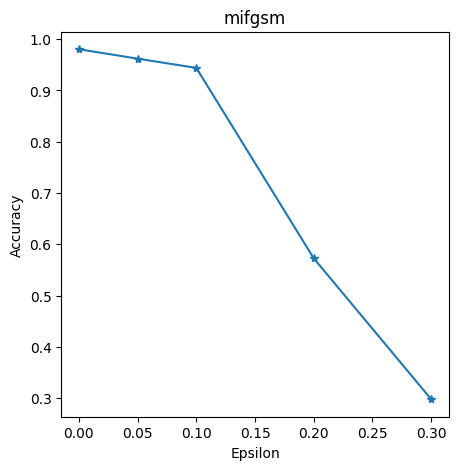

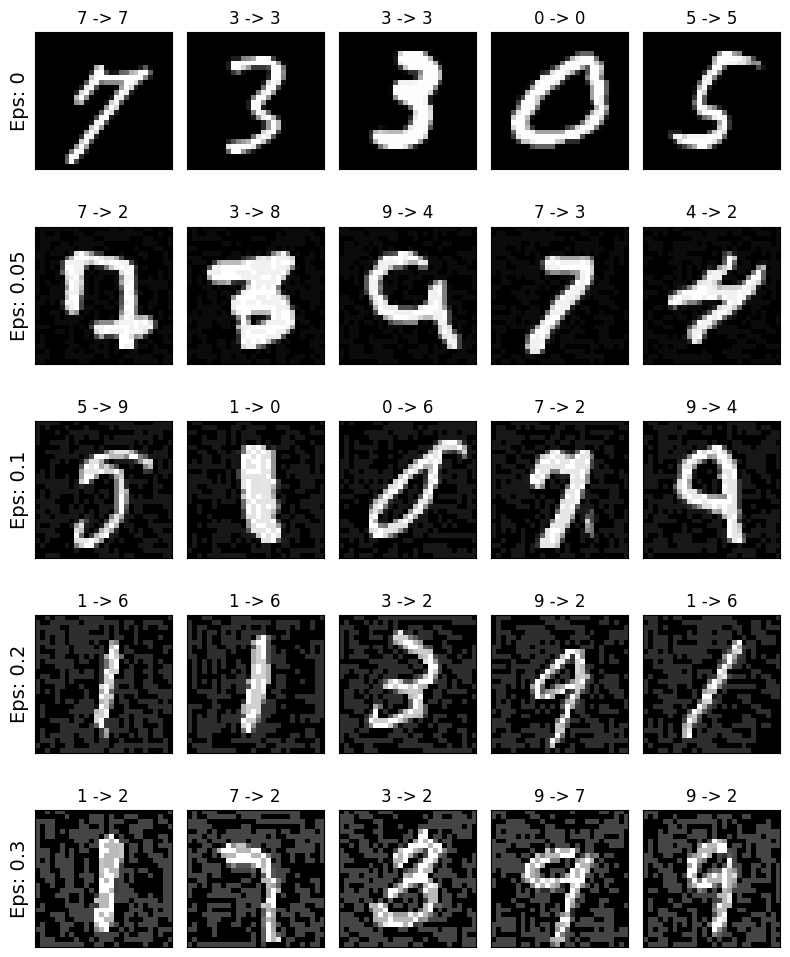

In [17]:
#epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
epsilons = [0,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [21]:
torch.cuda. is_available()

True

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def test_and_evaluate(model, device, test_loader, epsilon, attack):
    correct = 0
    all_preds = []
    all_targets = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            continue
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data, epsilon, data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data, epsilon, data_grad)
        
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        
        all_targets.extend(target.view_as(final_pred).cpu().numpy())
        all_preds.extend(final_pred.cpu().numpy())
        
        if final_pred.item() == target.item():
            correct += 1
            
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    return all_targets, all_preds

# Choose an epsilon value to generate report for
epsilon = 0.3  # Example epsilon
attack = "fgsm"  # Example attack
targets, preds = test_and_evaluate(model, device, test_loader, epsilon, attack)

# Generate confusion matrix
conf_matrix = confusion_matrix(targets, preds)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(targets, preds)
print("Classification Report:\n", class_report)


Epsilon: 0.3	Test Accuracy = 2648 / 10000 = 0.2648
Confusion Matrix:
 [[ 43   3 452  24   0  64 355  17   0   2]
 [  0  19 333   1  17  15 735   7   0   0]
 [  1   2 823   5   2   1 167  17   0   0]
 [  3   6 493  57   5  38 380  20   0   2]
 [  0   3 248   3 373  10 327   9   0   0]
 [  4   2 166  12   8 149 501  26   0   1]
 [  1   2  79   2   6   4 854   1   0   0]
 [  7  12 512  12   9  46 102 300   0   7]
 [  5   4 551  27   9  28 268  27  16   3]
 [  3   6 573  17  33  35 240  67   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.04      0.08       960
           1       0.32      0.02      0.03      1127
           2       0.19      0.81      0.31      1018
           3       0.36      0.06      0.10      1004
           4       0.81      0.38      0.52       973
           5       0.38      0.17      0.24       869
           6       0.22      0.90      0.35       949
           7       0.61      0.30      0.4